In [1]:
# Обработка/манипулирование данными
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
import re
from unidecode  import unidecode
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
# Визуализация данных
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import seaborn as sns

In [3]:
# Визуализация результата тематического моделирования
import pyLDAvis.sklearn

In [4]:
# Стоп-слова, токенизатор, стеммер
import nltk
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [5]:
# Sklearn
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [6]:
# Gensim
import gensim
from gensim.parsing.preprocessing import remove_stopwords

C:\Users\cavab\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [7]:
# Spacy 
import spacy

In [8]:
# Загружаем данные
trump_df = pd.read_csv('hashtag_donaldtrump.csv', lineterminator='\n')
biden_df = pd.read_csv('hashtag_joebiden.csv', lineterminator='\n')

print ('Общее количество записей в наборе данных Трампа: ', trump_df.shape)
print ('Общее количество записей в наборе данных Байдена: ', biden_df.shape)

Общее количество записей в наборе данных Трампа:  (970919, 21)
Общее количество записей в наборе данных Байдена:  (776886, 21)


In [9]:
# Удаляем ненужные столбцы
irrelevant_columns = ['user_name', 'user_screen_name', 'user_description', 'user_join_date', 'collected_at']
trump_df = trump_df.drop(columns = irrelevant_columns)
biden_df = biden_df.drop(columns = irrelevant_columns)

In [10]:
# Меняем имена некоторых столбцов для удобства анализа
trump_df = trump_df.rename(columns = {"likes": "Likes", "retweet_count": "Retweets",
                                   "state": "State", "user_followers_count": "Followers"})
biden_df = biden_df.rename(columns = {"likes": "Likes", "retweet_count": "Retweets",
                                   "state": "State", "user_followers_count": "Followers"})

In [11]:
# Переименуем United States of America в United States 
d = {"United States of America":"United States"}
trump_df['country'].replace(d, inplace=True)

In [12]:
biden_df['country'].replace(d, inplace=True)

In [13]:
# Создаем новый датасет с твитами, опубликованными только в США
trump_usa_df = trump_df.loc[trump_df['country'] == "United States"]
biden_usa_df = biden_df.loc[biden_df['country'] == "United States"]

In [14]:
# Удаляем пустые строки
trump_usa_df = trump_usa_df.dropna()
biden_usa_df = biden_usa_df.dropna()

In [15]:
# Проверяем размер данных
print('Общее количество записей в наборе данных Trump USA: ', trump_usa_df.shape)
print('Общее количество записей в наборе данных Trump Biden USA: ', biden_usa_df.shape)

Общее количество записей в наборе данных Trump USA:  (101953, 16)
Общее количество записей в наборе данных Trump Biden USA:  (90639, 16)


In [16]:
trump_usa_df['initial_dataset'] = 'trump'
biden_usa_df['initial_dataset'] = 'biden'

In [17]:
# Объединение данные в единый финальных датасет
twitter_usa_df = pd.concat([trump_usa_df, biden_usa_df], ignore_index = True)
# Найдем дубликаты
twitter_usa_df_duplicates = twitter_usa_df[twitter_usa_df.duplicated(['tweet_id'], keep = False)]

In [18]:
#Удаляем дубликаты 
trump_usa_df = trump_usa_df[~trump_usa_df.tweet_id.isin(twitter_usa_df_duplicates.tweet_id)]
biden_usa_df = biden_usa_df[~biden_usa_df.tweet_id.isin(twitter_usa_df_duplicates.tweet_id)]
twitter_usa_df.drop_duplicates(subset='tweet_id', keep = False, inplace = True)

In [19]:
# Проверяем размер данных в финальном датасете
print('Общее количество записей в наборе данных Trump и Biden USA: ', twitter_usa_df.shape)

Общее количество записей в наборе данных Trump и Biden USA:  (152376, 17)


In [20]:
# Создаем функцию для очистки текста
def clean_text(text):
    text=unidecode(text)
    text=text.lower() # Приведение к строчной форме
    text=re.sub(r'&',' ',text) # Удаляем ampersand (заменяет and)
    text=re.sub(r'[^\sa-zA-Z0-9@\[\]]',' ',text)# Удаляем специальные знаки
    text=re.sub(r'@[A-Za-z0-9]+','',text) # Удаляем упоминания других пользователей Twitter 
    text=re.sub(r'#','',text)    
    text=re.sub(r'RT[\s]+','',text)
    text=remove_stopwords(text) # Удаляем стоп-слова
    text=re.sub(r'http\S+', '', text) # Удаляем все ссылки 
    text=re.sub(r'https?:\/\/\S+','',text)
    text=re.sub(r'donal\S+', ' ', text) # Удаляем упоминания имен кандидатов
    text=re.sub(r'trum\S+', ' ', text)
    text=re.sub(r'donaldtrum\S+', ' ', text)
    text=re.sub(r'joe\S+', ' ', text)   
    text=re.sub(r'biden\S+', ' ', text)
    text=re.sub(r'joebide\S+', ' ', text)
    text=re.sub(r'vot\S+', ' ', text) # Удаляем частотные слова vote и election
    text=re.sub(r'electio\S+', ' ', text)
    text=re.sub(r'/s\s', '', text) # Удаляем единичные буквы s и t 
    text=re.sub(r'/t\s', '', text)
    return text

# Применяем функцию для очистки текста
trump_usa_df['cleaned_tweet'] = trump_usa_df.tweet.apply(lambda x: clean_text(x))
biden_usa_df['cleaned_tweet'] = biden_usa_df.tweet.apply(lambda x: clean_text(x))
twitter_usa_df['cleaned_tweet'] = twitter_usa_df['tweet'].apply(lambda x: clean_text(x))

In [21]:
# Создаем функцию для преобразование тега nltk в тег wordnet
lemmatizer = WordNetLemmatizer()
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None
    

In [22]:
# Создаем функцию для лемматизации текста
def lemmatize_sentence(sentence):
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence)) 
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:  
                lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [23]:
# Применяем функцию для лемматизации текста
trump_usa_df['lemmat_tweet'] = trump_usa_df.cleaned_tweet.apply(lambda x: lemmatize_sentence(x))
biden_usa_df['lemmat_tweet'] = biden_usa_df.cleaned_tweet.apply(lambda x: lemmatize_sentence(x))
twitter_usa_df['lemmat_tweet'] = twitter_usa_df.cleaned_tweet.apply(lambda x: lemmatize_sentence(x))

In [24]:
# Подготовка текста для анализа частотности для всех твитов
list_text = []
for string in twitter_usa_df['lemmat_tweet']:
    list_text.append(string)
list_text

str_text = str(list_text)
tokens = word_tokenize(str_text)
txt_tokens = [word.lower() for word in tokens if word.isalpha()]

In [25]:
# Сравним результаты очистки и подготовки твитов с оригинальным текстов
pd.options.display.max_colwidth = 50
print(twitter_usa_df[['tweet', 'cleaned_tweet', 'lemmat_tweet']].head(3))

                                               tweet  \
0  #Trump: As a student I used to hear for years,...   
1  You get a tie! And you get a tie! #Trump ‘s ra...   
3  #Trump #PresidentTrump #Trump2020LandslideVict...   

                                       cleaned_tweet  \
0    student hear years years heard china 2019 1 ...   
1               tie tie   s rally iowa  t jjaluumh5d   
3    president      maga kag 4moreyears america a...   

                                        lemmat_tweet  
0  student hear year year heard china 2019 1 5 t ...  
1                  tie tie s rally iowa t jjaluumh5d  
3  president maga kag 4moreyears america americaf...  


In [26]:
# Преобразуем дату в pandas datetime формат
twitter_usa_df['created_at'] = pd.to_datetime(twitter_usa_df['created_at'])

In [27]:
# Проверяем период во время которого были собраны данные 
print (f"Данные собраны с {twitter_usa_df.created_at.min()}")
print (f"Данные собраны по {twitter_usa_df.created_at.max()}")

Данные собраны с 2020-10-15 00:00:02
Данные собраны по 2020-11-08 23:58:44


In [28]:
# Создаем датасет с частотностью твитов согласно дате
cnt_srs = twitter_usa_df['created_at'].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()

C:\Users\cavab\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


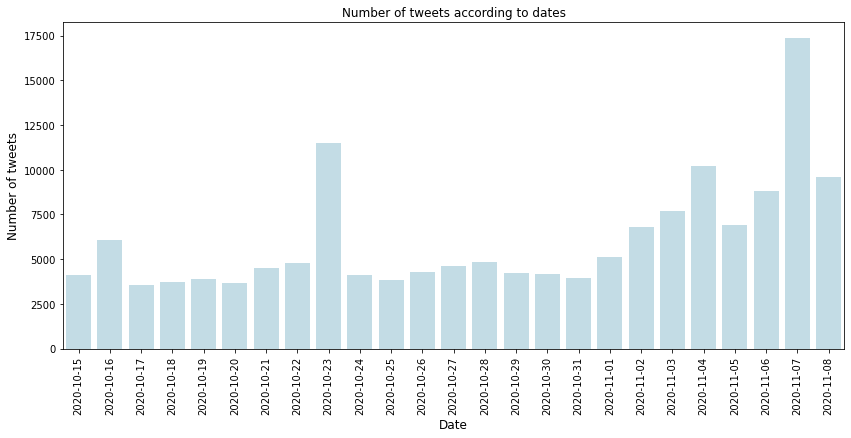

In [29]:
# Визуализация количества твитов согласно дате
plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='lightblue')
plt.xticks(rotation='vertical')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of tweets', fontsize=12)
plt.title("Number of tweets according to dates")
plt.show()

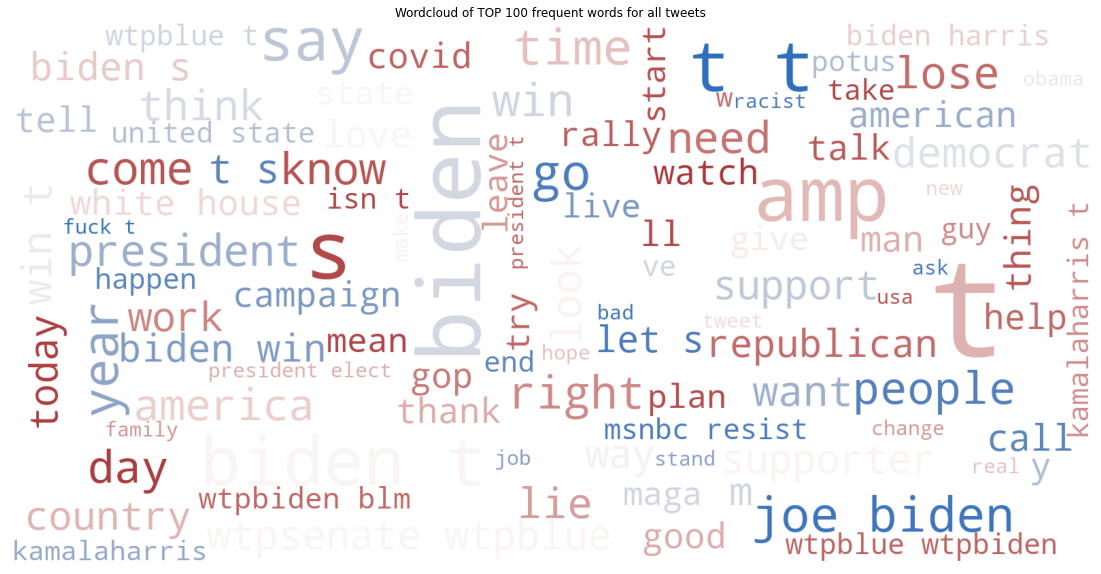

In [30]:
# Создаем текст для облака частотных слова
text_wordcloud = ' '.join(map(str, txt_tokens))
wordcloud = WordCloud(width=1600, height=800, max_font_size=200, max_words=100, colormap='vlag', background_color="white", collocations=True).generate(text_wordcloud)

# Визуализация 
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.title("Wordcloud of TOP 100 frequent words for all tweets")
plt.axis("off")
plt.show()

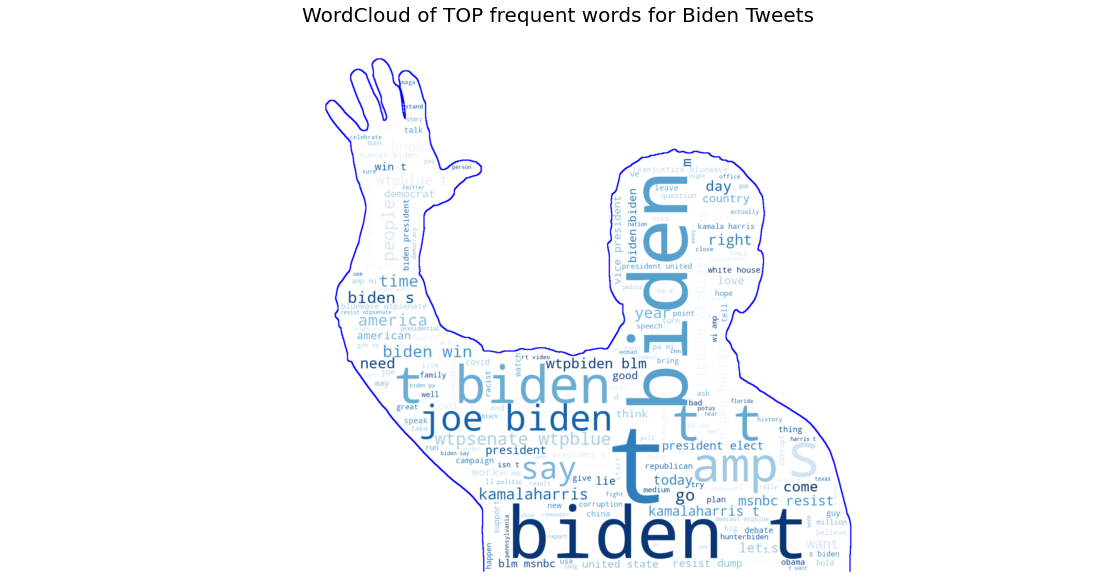

In [31]:
list_text = []
for string in biden_usa_df['lemmat_tweet']:
    list_text.append(string)
list_text

text_biden = str(list_text)
tkns_biden = word_tokenize(text_biden)
tokens_biden = [word.lower() for word in tkns_biden if word.isalpha()]
tokens_biden = ' '.join(map(str, tokens_biden))

# Загружаем портрет Байдена и используем np.array для преобразования файла в массив
biden_mask = np.array(Image.open('biden.png'))
biden_mask = np.where(biden_mask > 3, 255, biden_mask)

# Создаем облако частотных слов
wordcloud = WordCloud(background_color = 'white',
                     contour_color='blue',
                     mask=biden_mask, colormap='Blues',
                     contour_width=4).generate(tokens_biden)

# Визуализация
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("WordCloud of TOP frequent words for Biden Tweets", fontsize = 20)
plt.axis('off')
plt.show()

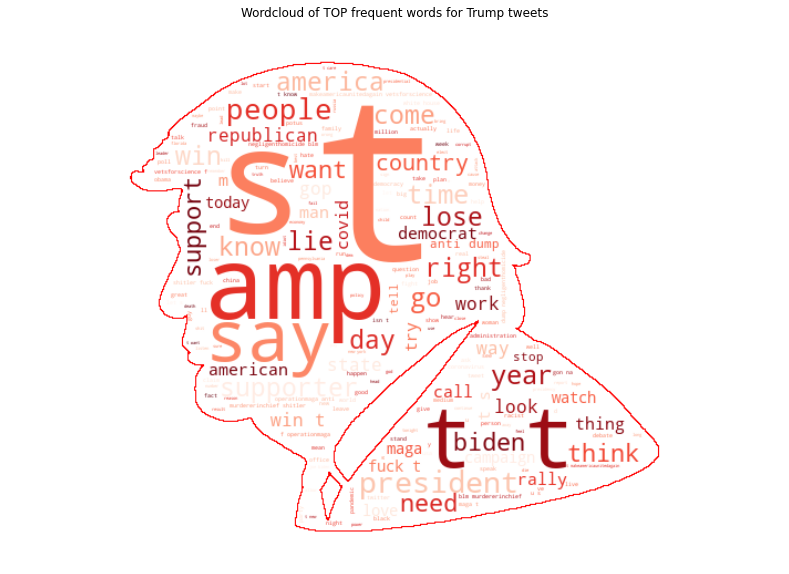

In [32]:
list_text = []
for string in trump_usa_df['lemmat_tweet']:
    list_text.append(string)
list_text

text_trump = str(list_text)
tokens_trump = word_tokenize(text_trump)
tokens_trump = [word.lower() for word in tokens_trump if word.isalpha()]
tokens_trump = ' '.join(map(str, tokens_trump)) 
trump_mask=np.array(Image.open('trump.png'))
trump_mask=np.where(trump_mask > 3, 255, trump_mask)

wordcloud = WordCloud(background_color='white',
                      contour_color='red',
                      mask=trump_mask, colormap='Reds',
                      contour_width=1).generate(tokens_trump)


# Визуализация 
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Wordcloud of TOP frequent words for Trump tweets')
plt.axis('off')
plt.show()

Text(0.5, 1.0, 'TOP 10 pairs of words which occured the texts')

<Figure size 1440x720 with 0 Axes>

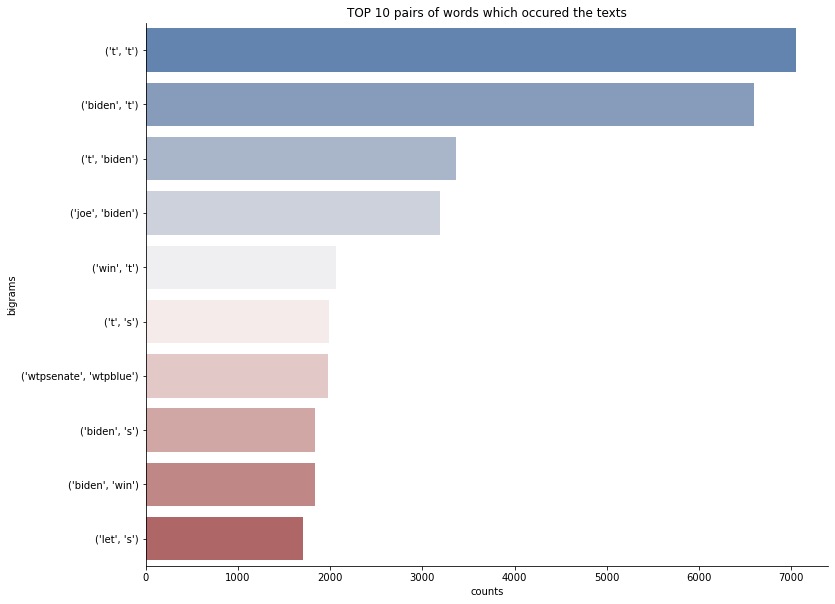

In [33]:
# Создаем датасет самых частотных биграммов
bigrams_series = (pd.Series(nltk.ngrams(txt_tokens, 2)).value_counts())[:10]
bigrams_top = pd.DataFrame(bigrams_series.sort_values(ascending=False))
bigrams_top = bigrams_top.reset_index().rename(columns={'index':'bigrams', 0:'counts'})

# Визуализация биграммов
plt.figure(figsize=(20,10))
sns.catplot(x = 'counts', y = 'bigrams', kind = 'bar', palette = 'vlag', data = bigrams_top, height=8.27, aspect=11.7/8.27)
plt.title("TOP 10 pairs of words which occured the texts")

In [34]:
tweet_retweet_max = twitter_usa_df.loc[twitter_usa_df['Retweets'].idxmax()]
tweet_retweet_max

created_at                                       2020-10-16 03:17:29
tweet_id                                       1316941303603728384.0
tweet              Tonight a woman in the audience of Trump's tow...
Likes                                                       165702.0
Retweets                                                     17652.0
source                                               Twitter Web App
user_id                                                  139823781.0
Followers                                                  2028360.0
user_location                                           New York, NY
lat                                                        40.712728
long                                                      -74.006015
city                                                        New York
country                                                United States
continent                                              North America
State                             

In [35]:
print(f" The tweet '{tweet_retweet_max.tweet}' was retweeted the most with {tweet_retweet_max.Retweets} number of retweets.")

 The tweet 'Tonight a woman in the audience of Trump's town hall began her question by telling him he has a great smile &amp; he's so handsome when he smiles. And when #JoeBiden is President, hopefully that woman will be able to access better vision care, bless her heart.' was retweeted the most with 17652.0 number of retweets.


In [36]:
vectorizer = CountVectorizer(analyzer='word',
min_df = 3,
stop_words = 'english',
lowercase = True,
token_pattern = '[a-zA-z0-9]{3,}',
max_features = 5000,)

data_matrix = vectorizer.fit_transform(twitter_usa_df.lemmat_tweet)

lda_model = LatentDirichletAllocation(
n_components = 12,
learning_method = 'online',
random_state = 62,
n_jobs = -1
)

lda_output = lda_model.fit_transform(data_matrix)

In [37]:
pyLDAvis.enable_notebook()
p = pyLDAvis.sklearn.prepare(lda_model, data_matrix, vectorizer, mds='tsne')
pyLDAvis.save_html(p, 'lda.html')

C:\Users\cavab\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
C:\Users\cavab\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


In [38]:
for i,topic in enumerate(lda_model.components_):
    print(f'Top 10 words for topic #{i + 1}:')
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #1:
['hold', 'bluewave', 'woman', 'resist', 'poll', 'believe', 'maga', 'lie', '2020', 'stop']


Top 10 words for topic #2:
['read', 'tax', 'united', 'like', 'china', 'day', 'come', 'year', 'state', 'president']


Top 10 words for topic #3:
['nevada', 'pay', 'god', 'yes', 'change', 'break', 'support', 'thank', 'debates2020', 'black']


Top 10 words for topic #4:
['los', 'son', 'person', 'celebrate', 'blue', 'hear', 'demcast', 'que', 'house', 'white']


Top 10 words for topic #5:
['fraud', 'night', 'gop', 'hunterbiden', 'let', 'watch', 'today', 'ballot', 'news', 'count']


Top 10 words for topic #6:
['corruption', 'administration', 'corrupt', 'big', 'history', 'medium', 'msnbc', 'country', 'love', 'amp']


Top 10 words for topic #7:
['kamala', 'vice', 'congratulation', 'speech', 'man', 'covid', 'say', 'life', 'presidential', 'wtpblue']


Top 10 words for topic #8:
['start', 'say', 'run', 'let', 'talk', '2020', 'hunter', 'great', 'joe', 'biden']


Top 10 words for t

In [39]:
topic_values = lda_model.transform(data_matrix)
twitter_usa_df['Topic'] = topic_values.argmax(axis=1)

twitter_usa_df[['tweet', 'Topic']].head(4)

,tweet,Topic
0,"#Trump: As a student I used to hear for years,...",6
1,You get a tie! And you get a tie! #Trump ‘s ra...,9
3,#Trump #PresidentTrump #Trump2020LandslideVict...,8
4,"#Trump: Nobody likes to tell you this, but som...",10


In [43]:
# Определяем топ ключевых слов в каждой теме
def show_topics(vectorize=vectorizer, lda_model=lda_model, n_words=100):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords
topic_keywords = show_topics(lda_model = lda_model, n_words = 100)

# Создаем датасет тема - ключевое слово
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]

In [47]:
# Создаем функцию для прогнозирования темы для новых твитов
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Загружаем модель 
nlp = spacy.load("en_core_web_sm")

# Создаем функцию для прогнозирования темы для новых твитов
def predict_topic(text, nlp=nlp):
    global sent_to_words
    global lemmatization
    # Подготовим текст
    mytext_2 = list(sent_to_words(text))
    # Лемматизация
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    # Векторизация
    mytext_4 = vectorizer.transform(mytext_3)
    # Трансформация модели
    topic_probability_scores = lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores

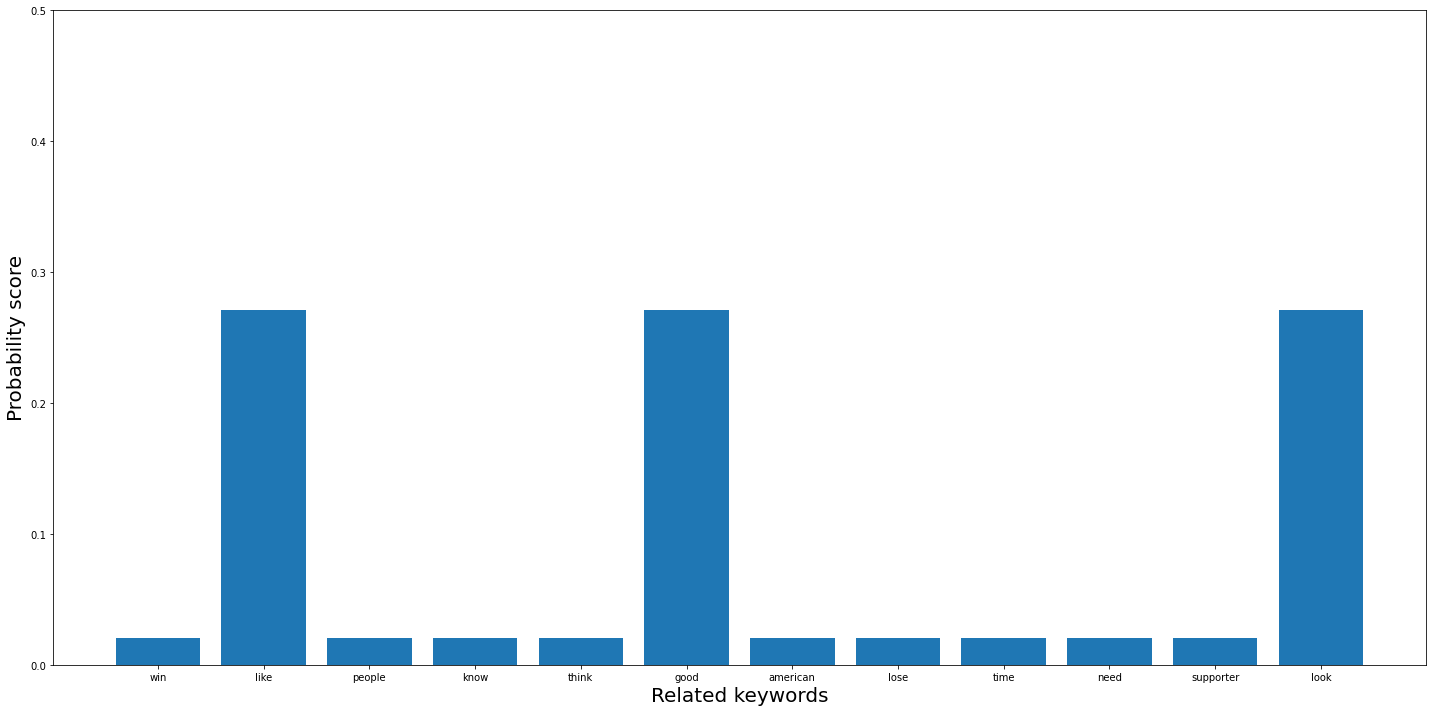

In [48]:
# Прогноз для нового твита "Biden is the best president for this country vote for him"
mytext =  ["Biden is the best president for this country vote for him"]
topic, prob_scores = predict_topic(text = mytext)

# Визуализация ключевых слов для нового твита
fig, ax = plt.subplots(figsize=(20,10))
plt.bar(topic[:12], prob_scores[0])
axes = plt.gca()
axes.set_ylim(0, 0.5)
axes.set_xlabel('Related keywords', fontsize = 20)
axes.set_ylabel('Probability score', fontsize = 20)

fig.tight_layout()
plt.show()

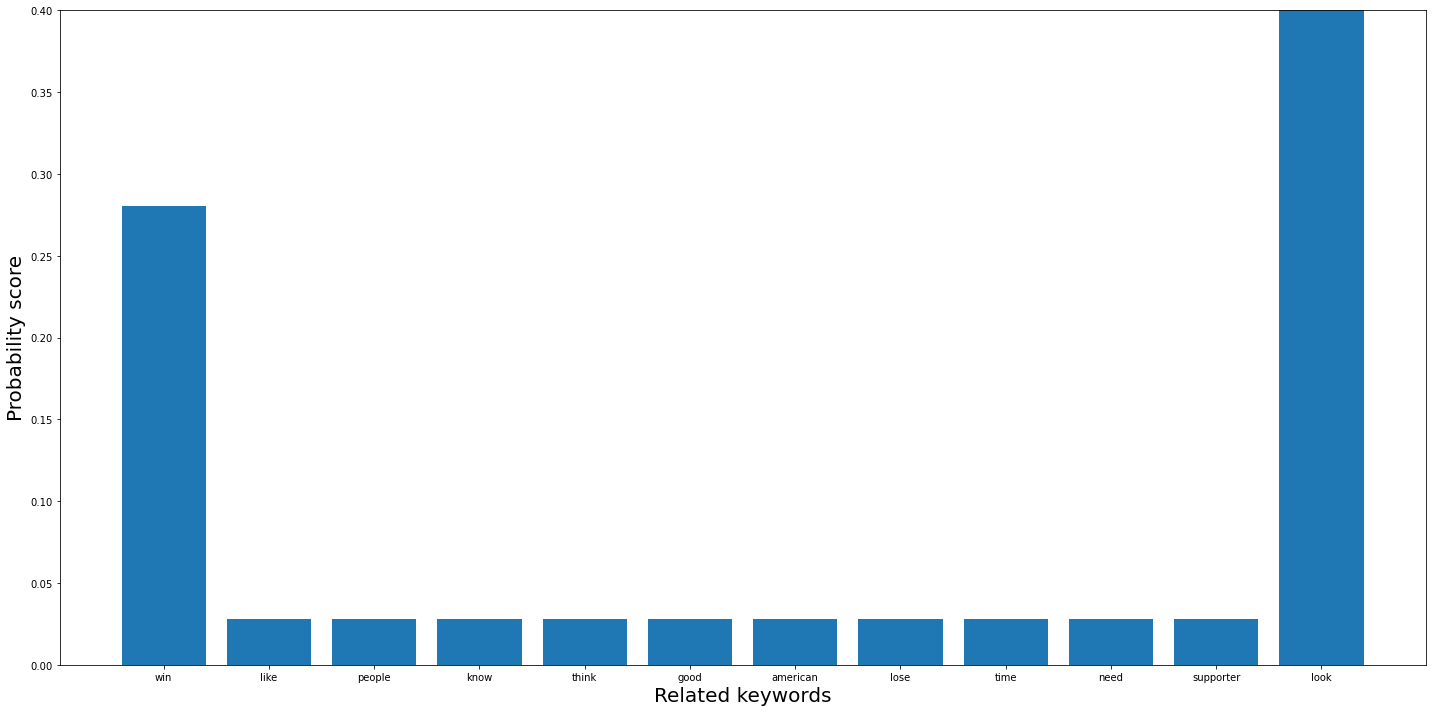

In [51]:
# Прогноз для нового твита "CNN lies to people"
mytext = ["CNN lies to people"]
topic, prob_scores = predict_topic(text = mytext)
# Визуализация ключевых слов для нового твита

fig, ax = plt.subplots(figsize=(20,10))
plt.bar(topic[:12], prob_scores[0])
axes = plt.gca()
axes.set_ylim(0, .4)
axes.set_xlabel('Related keywords', fontsize = 20)
axes.set_ylabel('Probability score', fontsize = 20)

fig.tight_layout()
plt.show()